In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
print(os.listdir("data"))

['socrata_metadata_2016-building-energy-benchmarking.json', '.DS_Store', 'socrata_metadata_2015-building-energy-benchmarking.json', 'clean-building-energy-benchmarking.csv', '2015-building-energy-benchmarking.csv', '2016-building-energy-benchmarking.csv']


In [2]:
raw = pd.read_csv("data/clean-building-energy-benchmarking.csv")
data = raw.copy()

In [3]:
data.head()

,DataYear,ENERGYSTARScore,GHGEmissionsIntensity,NumberofBuildings,NumberofFloors,OSEBuildingID,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,SiteEnergyUse(kBtu),...,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,ENERGYSTARCertified
0,2015,65.0,2.64,1.0,12.0,1,88434,0,88434,6981428.0,...,0,0,0,0,0,0,0,0,0,0
1,2015,51.0,2.38,1.0,11.0,2,88502,15064,103566,8354235.0,...,0,0,0,0,0,0,0,0,0,0
2,2015,18.0,1.92,1.0,41.0,3,961990,0,961990,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2015,NaN,NaN,1.0,10.0,5,61320,0,61320,28229320.0,...,0,0,0,0,0,0,0,0,0,0
4,2015,67.0,4.02,1.0,18.0,8,107430,12460,119890,14829099.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# TotalGHGEmissions

In [5]:
from sklearn.impute import SimpleImputer

df = data.copy()

imputer = SimpleImputer()
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [6]:
X = df.drop(["TotalGHGEmissions", "SiteEnergyUseWN(kBtu)", "ENERGYSTARScore"], axis=1)
y = df[["TotalGHGEmissions"]]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [10]:
lr = LinearRegression()
lr.fit(X_train_std, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
y_predicted = lr.predict(X_test_std)
print("Root Mean squared error: %.2f"% np.sqrt(mean_squared_error(y_test, y_predicted)))
print('R2 : %.2f' % r2_score(y_test, y_predicted))

Root Mean squared error: 74.23
R2 : 0.65


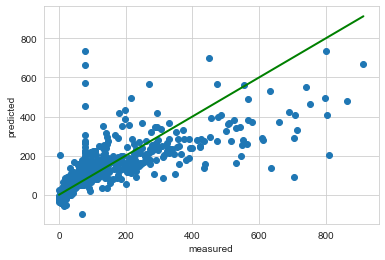

In [12]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, c="g")
ax.set_xlabel("measured")
ax.set_ylabel("predicted")
plt.show()

## Ridge Regression

In [13]:
from sklearn.linear_model import Ridge

In [14]:
rr = Ridge(alpha=0.01)
rr.fit(X_train_std, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [15]:
y_predicted = rr.predict(X_test_std)
print("Root Mean squared error: %.2f"% np.sqrt(mean_squared_error(y_test, y_predicted)))
print('R2 : %.2f' % r2_score(y_test, y_predicted))

Root Mean squared error: 74.26
R2 : 0.65


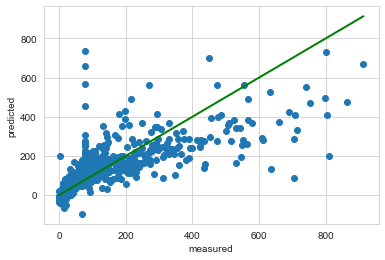

In [16]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, c="g")
ax.set_xlabel("measured")
ax.set_ylabel("predicted")
plt.show()

## Lasso

In [17]:
from sklearn.linear_model import Lasso

In [18]:
lasso = Lasso()
lasso.fit(X_train_std,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [19]:
y_predicted = lasso.predict(X_test_std)
print("Root Mean squared error: %.2f"% np.sqrt(mean_squared_error(y_test, y_predicted)))
print('R2 : %.2f' % r2_score(y_test, y_predicted))

Root Mean squared error: 74.27
R2 : 0.65


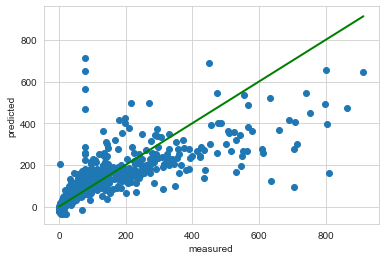

In [20]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, c="g")
ax.set_xlabel("measured")
ax.set_ylabel("predicted")
plt.show()